# Implementation of a Devito skew self adjoint VTI anisotropic variable density visco- pseudo- acoustic isotropic modeling operator -- Nonlinear and Linearized Ops

## This operator is contributed by Chevron Energy Technology Company (2020)

This operator is based on simplfications of the systems presented in:
<br>**Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1

## Introduction 

The goal of this tutorial set is to generate and prove correctness of modeling and inversion capability in Devito for **VTI anisotropic variable density visco- pseudo- acoustics** using an energy conserving form of the wave equation. We describe how the linearization of the energy conserving *skew self adjoint* system with respect to modeling parameters allows using the same modeling system for all nonlinear and linearized forward and adjoint finite difference evolutions. There are two notebooks in this series:

##### 1. Implementation of a Devito skew self adjoint VTI anisotropic variable density visco- pseudo- acoustic isotropic modeling operator -- Nonlinear and Linearized Ops
- Implement the nonlinear modeling operations. 
- [ssa_11_vti_implementation.ipynb](ssa_11_vti_implementation.ipynb)

##### 2. Implementation of a Devito skew self adjoint VTI anisotropic variable density visco- pseudo- acoustic isotropic modeling operator -- Correctness Testing
- Tests the correctness of the implemented operators.
- [ssa_12_vti_correctness.ipynb](ssa_12_vti_correctness.ipynb)

There are similar series of notebooks implementing and testing operators for isotropic and TTI anisotropy ([README.md](README.md)).

## Important note

This notebook and those following assume familiarity with the work shown in the first 3 notebooks. The introductory notebook In particular has information on the use of skew symmetric derivatives, our use of a dissipation only attenuation term, and motivation for implementing that attenuation term with a backward time difference. 

## Outline 
1. Define symbols and notation
1. The SSA VTI wave equation
1. The nonlinear operator
1. The Jacobian operator
1. The adjoint of the Jacobian operator
1. Derive time update equations
1. Create the Devito grid and model fields 
1. Implement, run, plot results for the nonlinear forward operator 
1. Implement, run, plot results for the Jacobian forward operator 
1. Implement, run, plot results for the Jacobian adjoint operator 
1. References

<a id="nl_symbols"></a>
## Table of symbols

| Symbol &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Description  | Dimensionality | 
| :---         | :---              | :--- |
| $\omega_c = 2 \pi f_c$ | center angular frequency | constant |
| $b(x,y,z)$   | buoyancy $(1 / \rho)$ | function of space |
| $Q(x,y,z)$   | Attenuation at frequency $\omega_c$ | function of space |
| $b(x,y,z)$   | buoyancy $(1 / \rho)$ | function of space |
| $f(x,y,z)$ | $V_s$ approximation defined: $f = 1 - \frac{\displaystyle V_s^2}{\displaystyle V_p^2}$ | function of space |
| $\epsilon(x,y,z)$ | Thomsen's weak anisotropy $\epsilon$  | function of space |
| $\delta(x,y,z)$ | Thomsen's weak anisotropy $\delta$  | function of space |
| $\tilde{\eta}(x,y,z)$ | Defined: $\tilde{\eta} = \sqrt{\frac{\displaystyle 2\bigl(\epsilon - \delta\bigr)}{\displaystyle f + 2\ \epsilon}}$ | function of space, note: $\sqrt{1 - \tilde{\eta}^2} = \frac{\displaystyle f + 2\delta}{\displaystyle f + 2\ \epsilon}$ |
| $Q(x,y,z)$   | Attenuation at frequency $\omega_c$ | function of space |
| $v(x,y,z)$ | Total P wave velocity ($v_0+\delta v$) | function of space |
| $v_0(x,y,z)$ | Background P wave velocity    | function of space |
| $\delta v(x,y,z)$ | Perturbation to P wave velocity    | function of space |
| $p(t,x,y,z)$ | Total quasi-P pressure wavefield ($u_0+\delta u$)| function of time and space |
| $p_0(t,x,y,z)$ | Background quasi-P pressure wavefield | function of time and space |
| $\delta p(t,x,y,z)$ | Perturbation to quasi-P pressure wavefield | function of time and space |
| $s(t,x,y,z)$ | Total quasi-S pressure wavefield ($u_0+\delta u$)| function of time and space |
| $s_0(t,x,y,z)$ | Background quasi-S pressure wavefield | function of time and space |
| $\delta s(t,x,y,z)$ | Perturbation to quasi-S pressure wavefield | function of time and space |
| $\overleftarrow{\partial_t}$ | shifted first derivative wrt $t$ | shifted 1/2 sample backward in time |
| $\partial_{tt}$ | centered second derivative wrt $t$ | centered in time |
| $\overrightarrow{\partial_x},\ \overrightarrow{\partial_y},\ \overrightarrow{\partial_z}$ | + shifted first derivative wrt $x,y,z$ | shifted 1/2 sample forward in space |
| $\overleftarrow{\partial_x},\ \overleftarrow{\partial_y},\ \overleftarrow{\partial_z}$ | - shifted first derivative wrt $x,y,z$ | shifted 1/2 sample backward in space |
| $g_1,\ g_2,\ g_3$ | Derivative operator notation for VTI and TTI operators | $\textit{see below}$ |
| $\tilde{g}_1,\ \tilde{g}_2,\ \tilde{g}_3$ | Derivative operators notation for VTI and TTI operators | $\textit{see below}$ |
| $\Delta_t, \Delta_x, \Delta_y, \Delta_z$ | sampling rates for $t, x, y , z$ | $t, x, y , z$ |  
| $q_p(t,x,y,z)$ | Quasi-P source | function of time, localized in space to source location |
| $q_s(t,x,y,z)$ | Quasi-S source | function of time, localized in space to source location |
| $r(t,x,y,z)$ | Receiver wavefield | function of time, localized in space to receiver locations |
| $F[m; q]$ | Forward nonlinear modeling operator | Nonlinear in $m$, linear in $q$: $\quad$ maps $m \rightarrow r$ |
| $\nabla F[m; q]\ \delta v$ | Forward Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta v \rightarrow \delta r$ |
| $\bigl( \nabla F[m; q] \bigr)^\top\ \delta r$ | Adjoint Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta r \rightarrow \delta v$ |
| $\Delta_t, \Delta_x, \Delta_y, \Delta_z$ | sampling rates for $t, x, y , z$ | $t, x, y , z$ | 
| $\theta,\ \phi$ | azimuth and tilt angle for TTI symmetry axis definition | function of space | 

## A word about notation 

We use the arrow symbols over derivatives $\overrightarrow{\partial_x}$ as a shorthand notation to indicate that the derivative is taken at a shifted location. For example:

- $\overrightarrow{\partial_x}\ u(t,x,y,z)$ indicates that the $x$ derivative of $u(t,x,y,z)$ is taken at $u(t,x+\frac{\Delta x}{2},y,z)$.

- $\overleftarrow{\partial_z}\ u(t,x,y,z)$ indicates that the $z$ derivative of $u(t,x,y,z)$ is taken at $u(t,x,y,z-\frac{\Delta z}{2})$.

- $\overleftarrow{\partial_t}\ u(t,x,y,z)$ indicates that the $t$ derivative of $u(t,x,y,z)$ is taken at $u(t-\frac{\Delta_t}{2},x,y,z)$.

We usually drop the $(t,x,y,z)$ notation from wavefield variables unless required for clarity of exposition, so that $u(t,x,y,z)$ becomes $u$.

## Derivative operator notation for VTI and TTI operators

The VTI and TTI operators are very similar, and a small change in derivative notation allows using the same form for both these operators. We introduce now notation suitable for both VTI and TTI systems, and continue below with the implementation of the VTI form.

We use the symbols $(g_1,\ g_2,\ g_3)$ and $(\tilde{g}_1,\ \tilde{g}_2,\ \tilde{g}_3)$ to indicate the *inside* and *outside* derivatives for these operators. For VTI, these operators map one-to-one into the usual orthogonal derivative operators $(\overrightarrow{\partial_x},\ \overrightarrow{\partial_y},\ \overrightarrow{\partial_z})$ and $(\overleftarrow{\partial_x},\ \overleftarrow{\partial_y},\ \overleftarrow{\partial_z})$. For TTI these operators involve both the usual derivatives and coordinate rotations. Below the TTI axes of symmetry are defined by azimumth $\theta$ and tilt angle $\phi$, specified in radians.

| Operator | &nbsp; &nbsp; &nbsp; VTI &nbsp; &nbsp; &nbsp; | &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; TTI &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | 
| :---: | :---: | :---: |
| $g_1(\cdot)$ | $\overrightarrow{\partial_x}(\cdot)$ | $
    + cos \theta\ cos \phi\ \overrightarrow{\partial_x} (\cdot) 
    + cos \theta\ sin \phi\ \overrightarrow{\partial_y} (\cdot)
    - sin \theta\ \overrightarrow{\partial_z} (\cdot)$ |
| $g_2(\cdot)$ | $\overrightarrow{\partial_y}(\cdot)$ | $
    - sin \phi\ \overrightarrow{\partial_x} (\cdot) 
    + cos \phi\ \overrightarrow{\partial_y} (\cdot)$ |
| $g_3(\cdot)$ | $\overrightarrow{\partial_z}(\cdot)$ | $
    + sin \theta\ cos \phi\ \overrightarrow{\partial_x} (\cdot) 
    + sin \theta\ sin \phi\ \overrightarrow{\partial_y} (\cdot)
    + cos \theta\ \overrightarrow{\partial_z} (\cdot)$ |
| $\tilde{g}_1(\cdot)$ | $ \overleftarrow{\partial_x}(\cdot)$ | $
    + \overleftarrow{\partial_x} \bigl( cos \theta\ cos \phi\ \cdot \bigr)
    + \overleftarrow{\partial_y} \bigl( cos \theta\ sin \phi\ \cdot \bigr)
    - \overleftarrow{\partial_z} \bigl( sin \theta\ \cdot \bigr)$ |
| $\tilde{g}_2(\cdot)$ | $\overleftarrow{\partial_y}(\cdot)$ | $
    - \overleftarrow{\partial_x} \bigl( sin \phi\ \cdot \bigr) 
    + \overleftarrow{\partial_y} \bigl( cos \phi\ \cdot \bigr)$ |
| $\tilde{g}_3(\cdot)$ | $\overleftarrow{\partial_z}(\cdot)$ | $
    + \overleftarrow{\partial_x} \bigl( sin \theta\ cos \phi\ \cdot \bigr)
    + \overleftarrow{\partial_y} \bigl( sin \theta\ sin \phi\ \cdot \bigr)
    + \overleftarrow{\partial_z} \bigl( cos \theta\ \cdot \bigr)$ |


#### Skew symmetry of operators $(g_1,\ \tilde{g}_1)$,  $(g_2,\ \tilde{g}_2)$,  $(g_3,\ \tilde{g}_3)$ 

Note that these pairs of operators are skew symmetric, which can be verified with random domain vectors $a$ and $b$ via the following adjoint tests:

$$
\begin{aligned}
g_1(a) \cdot b\ &\approx\ - a \cdot \tilde{g}_1(b) \\[5pt]
g_2(a) \cdot b\ &\approx\ - a \cdot \tilde{g}_2(b) \\[5pt]
g_3(a) \cdot b\ &\approx\ - a \cdot \tilde{g}_3(b) 
\end{aligned}
$$

Note we perform this unit test below as we did in the 1st isotropic notebook.

<a id="nl_we"></a>
## The Nonlinear Operator

Our skew self adjoint VTI anisotropic wave equation has two coupled equations for quasi-P state variable $p$ and quasi-shear state variable $s$, and is written:

$$
\begin{aligned}
\frac{b}{v^2} \left( \frac{\omega_c}{Q} \overleftarrow{\partial_t}\ p + \partial_{tt}p \right) =\ 
   & \tilde{g}_1 \biggl[b\ \bigl(1 + 2\ \epsilon\bigr)\ g_1\ p \biggr] + 
     \tilde{g}_2 \biggl[b\ \bigl(1 + 2\ \epsilon\bigr)\ g_2\ p \biggr] \\[5pt]  
   & \tilde{g}_3 \biggl[b\ \bigl(1 - f\ \tilde{\eta}^2\bigr)\ g_3\ p + 
         b\ f\ \tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ g_3\ s \biggr] + q_p \\[15pt]
%     
\frac{b}{v^2} \left( \frac{\omega_c}{Q} \overleftarrow{\partial_t}\ s + \partial_{tt}s \right) =\ 
   & \tilde{g}_1 \biggl[b\ \bigl(1 - f\bigr)\ g_1\ s \biggr] + 
     \tilde{g}_2 \biggl[b\ \bigl(1 - f\bigr)\ g_2\ s \biggr] + \\[5pt]
   & \tilde{g}_3 \biggl[b\ \bigl(1 - f + f\ \tilde{\eta}^2\bigr)\ g_3\ s + 
         b\ f\ \tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ g_3\ p \biggr] + q_s
\end{aligned}
$$

#### Coupling between quasi-P and quasi-S state variables

You will note that the two equations are coupled only via vertical derivatives and the terms:

$$
\begin{aligned}
&\tilde{g}_3 \left[b\ f\ \tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ g_3\ s \right] \quad \text{for quasi-P} \\[5pt]
&\tilde{g}_3 \left[b\ f\ \tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ g_3\ p \right] \quad \text{for quasi-S}
\end{aligned}
$$

This means there are *zero horizontal cross terms* between the quasi-P and quasi-S state variables $p, s$ for the VTI pseudo- acoustic system.

We will drop the quasi-S source $q_s$ in further exposition as we only inject into the quasi-P wavefield.

#### Use for nonlinear and linearized operations

As discussed in the previous notebooks, this energy conserving skew self adjoint form allows using the same equations for all nonlinear and linearized operations required for quasi- Newton optimization. Some other widely utilized non energy conserving formulations (not referenced here directly) can provide unstable linearized adjoints, and thus unstable gradients for updating anisotropy parameters.  

#### Operator notation
In operator notation, where the operator is nonlinear with respect to model $m$ to the left of semicolon inside the square brackets, and linear with respect to the source $q$ to the right of semicolon inside the square brackets.

$$
F[m; q] = r
$$

Note that for this VTI aniostropic system, the material parameter model vector $m$ is defined as:

$$
m = 
\begin{bmatrix}
v \\ \epsilon \\\tilde{\eta} 
\end{bmatrix}
$$

## The Jacobian operator

In this section we linearize about a background model and take the derivative of the nonlinear operator to obtain the Jacobian forward operator. 

#### Operator notation
In operator notation, where the derivative of the modeling operator is now linear in the model perturbation vector $\delta m$, the Jacobian operator maps a perturbation in the material parameter model $\delta m$ into a perturbation in the receiver wavefield $\delta r$. 

$$
\nabla F[m; q]\ \delta m = \delta r
$$

Note that for this VTI anisotropic system, the perturbation to the material parameter model vector $\delta m$ is defined as:

$$
\delta m = 
\begin{bmatrix}
\delta v \\ \delta \epsilon \\ \delta \tilde{\eta} 
\end{bmatrix}
$$

#### 1. Begin by simplifying notation 
To simplify the treatment below we introduce the operator $L_t[\cdot]$, accounting for the time derivatives inside the parentheses on the left hand side of the wave equation. 

$$
L_t[\cdot] \equiv \frac{\omega_c}{Q} \overleftarrow{\partial_t}[\cdot] + \partial_{tt}[\cdot]
$$

Next we re-write the coupled wave equation using this notation.

$$
\begin{aligned}
\frac{b}{v^2} L_t[p] =\ 
   & \tilde{g}_1 \biggl[b\ \bigl(1 + 2\ \epsilon\bigr)\ g_1\ p \biggr] + 
     \tilde{g}_2 \biggl[b\ \bigl(1 + 2\ \epsilon\bigr)\ g_2\ p \biggr] \\[5pt]  
   & \tilde{g}_3 \biggl[b\ \bigl(1 - f\ \tilde{\eta}^2\bigr)\ g_3\ p + 
         b\ f\ \tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ g_3\ s \biggr] + q_p \\[15pt]
\frac{b}{v^2} L_t[s] =\ 
   & \tilde{g}_1 \biggl[b\ \bigl(1 - f\bigr)\ g_1\ s \biggr] + 
     \tilde{g}_2 \biggl[b\ \bigl(1 - f\bigr)\ g_2\ s \biggr] + \\[5pt]
   & \tilde{g}_3 \biggl[b\ \bigl(1 - f + f\ \tilde{\eta}^2\bigr)\ g_3\ s + 
         b\ f\ \tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ g_3\ p \biggr] + q_s
\end{aligned}
$$

#### 2. Linearize
To linearize we treat material parameters as the sum of background and perturbation models, and total quasi-P and quasi-S pressures as sums of background and perturbation pressures.

$$
\begin{aligned}
v &= v_0 + \delta v \\[5pt]
\epsilon &= \epsilon_0 + \delta \epsilon \\[5pt]
\tilde{\eta} &= \tilde{\eta}_0 + \delta \tilde{\eta} \\[5pt]
p &= p_0 + \delta p \\[5pt]
s &= s_0 + \delta s
\end{aligned}
$$

Rewrite wave equations with these material parameter and state variable expansions:

$$
\begin{aligned}
\frac{b}{(v_0+\delta v)^2} L_t[p_0 + \delta p] =\ 
   & \tilde{g}_1 \biggl\{b\ \bigl[1 + 2\ \left(\epsilon_0 + \delta \epsilon\right) \bigr]\ 
       g_1\ (p_0 + \delta p) \biggr\}\ + \\[5pt]
   & \tilde{g}_2 \biggl\{b\ \bigl[1 + 2\ \left(\epsilon_0 + \delta \epsilon\right) \bigr]\ 
       g_2\ (p_0 + \delta p) \biggr\}\ + \\[5pt]
   & \tilde{g}_3 \biggl\{b\ \bigl[1 - f\ {\left(\tilde{\eta}_0 + \delta \tilde{\eta}\right)}^2\bigr]\ 
       g_3\ (p_0 + \delta p) \biggr\}\ + \\[5pt]
   & \tilde{g}_3 \biggl\{b\ f\ \left(\tilde{\eta}_0 + \delta \tilde{\eta}\right)\ 
       \sqrt{1 - \left(\tilde{\eta}_0 + \delta \tilde{\eta}\right)^2}\ g_3\ (s_0 + \delta s) \biggr\} + q_p \\[15pt]
%     
\frac{b}{(v_0+\delta v)^2} L_t[s_0 + \delta_s] =\ 
   & \tilde{g}_1 \biggl\{b\ \bigl[1 - f\bigr]\ g_1\ (s_0 + \delta s) \biggr\}\ + \\[5pt]
   & \tilde{g}_2 \biggl\{b\ \bigl[1 - f\bigr]\ g_2\ (s_0 + \delta s) \biggr\}\ + \\[5pt]
   & \tilde{g}_3 \biggl\{b\ \bigl[p1 - f + f\ \left(\tilde{\eta}_0 + \delta \tilde{\eta}\right)^2\bigr]\ 
       g_3\ (s_0 + \delta s) \biggr\}\ + \\[5pt] 
   & \tilde{g}_3 \biggl\{b\ f\ \left(\tilde{\eta}_0 + \delta \tilde{\eta}\right)\ 
       \sqrt{1 - \left(\tilde{\eta}_0 + \delta \tilde{\eta}\right)^2}\ g_3\ (p_0 + \delta p) \biggr\} \\[15pt]
\end{aligned}
$$

#### 3. Take derivative w.r.t. model parameters
Next we take the derivatives with respect to $v$, $\epsilon$, and $\tilde{\eta}$ keeping only terms up to first order in perturbations, and subtract the background model PDE equation. 

As in the isotropic case shown in the first notebook, we end up with the exact same equation as used for the nonlinear forward but with state variables $p, s$ replaced with state variables $\delta p, \delta s$; and with source terms $q_p, q_s$ replaced with Born source terms related to the derivatives of the linearization of the material parameters. 

$$
\begin{aligned}
\bigl\{ \texttt{Born } p\bigr\} =\ & \frac{2\ b\ \delta v}{v_0^3} L_t[p_0] 
    + \tilde{g}_1 \biggl[ 2\ b\ \delta \epsilon\ g_1\ p_0 \biggr]
    + \tilde{g}_2 \biggl[ 2\ b\ \delta \epsilon\ g_2\ p_0 \biggr] \\[5pt]
  &\quad + \tilde{g}_3 \biggl[ 
    - 2\ b\ f\ \tilde{\eta}_0\ \delta \tilde{\eta}\ g_3\ p_0 
    + \frac{b\ f\ \bigl(1 - 2\ \tilde{\eta}_0^2 \bigr)}{\sqrt{1 - \tilde{\eta}^2} }\ g_3\ m_0 
    \biggr]
\\[15pt]
%     
\bigl\{ \texttt{Born } s\bigr\} =\ & \frac{2\ b\ \delta v}{v_0^3} L_t[s_0] \\[5pt]
  &\quad +\ \tilde{g}_3 \biggl[ 
    - 2\ b\ f\ \tilde{\eta}_0\ \delta \tilde{\eta}\ g_3\ m_0 
    + \frac{b\ f\ \bigl(1 - 2\ \tilde{\eta}_0^2 \bigr)}{\sqrt{1 - \tilde{\eta}^2} }\ g_3\ p_0 
    \biggr]
\end{aligned}
$$

The Jacobian forward finite difference evolution is solved forward in time in the reference material parameter model $(v_0, \epsilon_0, \tilde{\eta}_0)$.

$$
\begin{aligned}
\frac{b}{v_0^2} L_t[\delta p] =\ 
   & \tilde{g}_1 \biggl[b\ \bigl(1 + 2\ \epsilon_0\bigr)\ g_1\ \delta p \biggr] + 
     \tilde{g}_2 \biggl[b\ \bigl(1 + 2\ \epsilon_0\bigr)\ g_2\ \delta p \biggr] + \\[5pt] 
   & \tilde{g}_3 \biggl[b\ \bigl(1 - f\ \tilde{\eta}_0^2\bigr)\ g_3\ \delta p
    + b\ f\ \tilde{\eta}_0\ \sqrt{1 - \tilde{\eta}_0^2}\ g_3\ \delta s \biggr] +
    \bigl\{\texttt{Born } p\bigr\} \\[15pt]
%     
\frac{b}{v_0^2} L_t[s] =\ 
   & \tilde{g}_1 \biggl[b\ \bigl(1 - f\bigr)\ g_1\ \delta s \biggr] + 
     \tilde{g}_2 \biggl[b\ \bigl(1 - f\bigr)\ g_2\ \delta s \biggr] + \\[5pt]
   & \tilde{g}_3 \biggl[b\ \bigl(1 - f + f\ \tilde{\eta}_0^2\bigr)\ g_3\ \delta 
    + b\ f\ \tilde{\eta}_0\ \sqrt{1 - \tilde{\eta}_0^2}\ g_3\ \delta p \biggr] +
    \bigl\{\texttt{Born } s\bigr\}
\end{aligned}
$$

## The adjoint of the Jacobian operator

In this section we introduce the adjoint of the Jacobian operator we derived above. The Jacobian adjoint operator maps a perturbation in receiver wavefield $\delta r$ into a perturbation in velocity model $\delta m$. In operator notation:

$$
\bigl( \nabla F[m; q] \bigr)^\top\ \delta r = \delta m
$$

#### 1. Solve the time reversed wave equation with the receiver perturbation as source
The PDE for the adjoint of the Jacobian is solved for the perturbation to the pressure wavefields $\widetilde{\delta p}, \widetilde{\delta s}$ by using the same wave equation as the nonlinear forward and the Jacobian forward, with the time reversed receiver wavefield perturbation $\widetilde{\delta r}$ injected as source. 

Note that we use $\widetilde{\delta p}, \widetilde{\delta s}$ and $\widetilde{\delta r}$ to indicate that we solve this finite difference evolution time reversed in the reference material parameter model $(v_0, \epsilon_0, \tilde{\eta}_0)$.

$$
\begin{aligned}
\frac{b}{v_0^2} L_t[\widetilde{\delta p}] =\ 
   & \tilde{g}_1 \biggl[b\ \bigl(1 + 2\ \epsilon_0\bigr)\ g_1\ \widetilde{\delta p} \biggr] + 
     \tilde{g}_2 \biggl[b\ \bigl(1 + 2\ \epsilon_0\bigr)\ g_2\ \widetilde{\delta p} \biggr] + \\[5pt] 
   & \tilde{g}_3 \biggl[b\ \bigl(1 - f\ \tilde{\eta}_0^2\bigr)\ g_3\ \widetilde{\delta p}
    + b\ f\ \tilde{\eta}_0\ \sqrt{1 - \tilde{\eta}_0^2}\ g_3\ \widetilde{\delta s} \biggr] +
    \widetilde{\delta r} \\[15pt]
%     
\frac{b}{v+0^2} L_t[s] =\ 
   & \tilde{g}_1 \biggl[b\ \bigl(1 - f\bigr)\ g_1\ \widetilde{\delta s} \biggr] + 
     \tilde{g}_2 \biggl[b\ \bigl(1 - f\bigr)\ g_2\ \widetilde{\delta s} \biggr] + \\[5pt]
   & \tilde{g}_3 \biggl[b\ \bigl(1 - f + f\ \tilde{\eta}_0^2\bigr)\ g_3\ \widetilde{\delta s}
    + b\ f\ \tilde{\eta}_0\ \sqrt{1 - \tilde{\eta}_0^2}\ g_3\ \widetilde{\delta p} \biggr]
\end{aligned}
$$

#### 2. Compute zero lag correlation  

We compute the perturbations to material parameters by zero lag correlation of the wavefield perturbations $\widetilde{\delta p}, \widetilde{\delta s}$ via the following expressions. Note we omit the dimensionality $(t,x,y,z)$ on wavefields for brevity.

$$
\begin{aligned}
\delta v(x,y,z) = \sum_t 
    \left\{ 
        \widetilde{\delta p}\ \frac{\displaystyle 2\ b}{\displaystyle v_0^3}\ L_t\bigl[p_0\bigr] +
        \widetilde{\delta s}\ \frac{\displaystyle 2\ b}{\displaystyle v_0^3}\ L_t\bigl[s_0\bigr]
    \right\}
\end{aligned}
$$

Note that this correlation can be more formally derived by examining the equations for two Green's functions, one for the background model ($m_0$) and wavefield ($u_0$), and one for for the total model $(m_0 + \delta m)$ and wavefield $(u_0 + \delta u)$, and subtracting to derive the equation for Born scattering.


## Solve for the time update equations

We next solve for the time update equations, in the same way as in the initial isotropic notebooks. 

#### 1. Temporal numerical derivatives, sorted into useful form
$$
\begin{aligned}
\overleftarrow{\partial_{t}}\ u &= \frac{\displaystyle u(t) - \
    u(t-\Delta_t)}{\displaystyle \Delta_t}\\[10pt]
% 
u(t+\Delta_t)\ &= \Delta_t^2\ \partial_{tt}u + 2\ u(t) - u(t-\Delta_t)
\end{aligned}
$$

#### 2. Solve the quasi-P and quasi-S wave equations for $\partial_{tt}p$ and $\partial_{tt}m$ 

$$
\begin{aligned}
\partial_{tt}p = \frac{m^2}{b}\ 
\biggl\{ 
   & \tilde{g}_1 \left[b\ \bigl(1 + 2\ \epsilon\bigr)\ g_1\ p \right] + 
     \tilde{g}_2 \left[b\ \bigl(1 + 2\ \epsilon\bigr)\ g_2\ p \right] + 
     \tilde{g}_3 \left[b\ \bigl(1 - f\ \tilde{\eta}^2\bigr) g_3\ p \right] \\[5pt]
+\ & \tilde{g}_3 \left[b\ f\ \tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ g_3\ m \right] + q_p 
\biggl\}\ - \frac{\omega_c}{Q} \overleftarrow{\partial_t}\ p \\[15pt]
% 
\partial_{tt}m = \frac{m^2}{b}\ 
\biggl\{ 
   & \tilde{g}_1 \left[b\ \bigl(1 - f\bigr)\ g_1\ m \right] + 
     \tilde{g}_2 \left[b\ \bigl(1 - f\bigr)\ g_2\ m \right] +
     \tilde{g}_3 \left[b\ \bigl(1 - f + f\ \tilde{\eta}^2\bigr)\ g_3\ m \right] \\[5pt] 
+\ & \tilde{g}_3 \left[b\ f\ \tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ g_3\ p \right]
\biggl\}\ - \frac{\omega_c}{Q} \overleftarrow{\partial_t}\ m
\end{aligned}
$$

**Note**: we now abbreviate the space parts of the wave equations (between the curly braces in the two equations above) in order to reduce repetition of long expressions.

#### 3. Plug $\overleftarrow{\partial_t} p, \overleftarrow{\partial_t} m, \partial_{tt}p, \partial_{tt}m$ from W.E. into the time update equations

$$
\begin{aligned}
p(t+\Delta_t) =\  
    & \frac{\Delta_t^2\ m^2}{b} \biggl\{ \texttt{Space P} \biggr\}
        - \Delta_t^2 \frac{\omega_c}{Q} \biggl( \frac{\displaystyle p(t) - p(t-\Delta_t)}
            {\displaystyle \Delta_t}\biggr) + 2\ p(t) - p(t-\Delta_t)\\[10pt]
% 
 =\ & \frac{\Delta_t^2\ m^2}{b} \biggl\{ \texttt{Space P} \biggr\} 
        + \biggl( 2 -  \Delta_t \frac{\omega_c}{Q} \biggr)\ p(t) 
        + \biggl( \Delta_t \frac{\omega_c}{Q} - 1 \biggr)\ p(t-\Delta_t)\\[20pt]
% 
p(t+\Delta_t) =\  
    & \frac{\Delta_t^2\ m^2}{b} \biggl\{ \texttt{Space M} \biggr\}
        - \Delta_t^2 \frac{\omega_c}{Q} \biggl( \frac{\displaystyle m(t) - m(t-\Delta_t)}
            {\displaystyle \Delta_t}\biggr) + 2\ m(t) - m(t-\Delta_t)\\[10pt]
% 
 =\ & \frac{\Delta_t^2\ m^2}{b} \biggl\{ \texttt{Space M} \biggr\} 
        + \biggl( 2 -  \Delta_t \frac{\omega_c}{Q} \biggr)\ m(t) 
        + \biggl( \Delta_t \frac{\omega_c}{Q} - 1 \biggr)\ m(t-\Delta_t)
\end{aligned}
$$


## Imports 

We have grouped all imports used in this notebook here for consistency.

In [1]:
import numpy as np
from sympy import sqrt
from examples.seismic import RickerSource, Receiver, TimeAxis
from devito import (Grid, Function, TimeFunction, SpaceDimension, Constant, 
                    Eq, Operator, solve, configuration)
from devito.finite_differences import Derivative
from devito.builtins import gaussian_smooth
from examples.seismic.skew_self_adjoint import setup_w_over_q

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer

# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline
mpl.rc('font', size=14)

# Make white background for plots, not transparent
plt.rcParams['figure.facecolor'] = 'white'

# We define 32 bit floating point as the precision type 
dtype = np.float32

# Set the default language to openmp
configuration['language'] = 'openmp'

# Set logging to debug, captures statistics on the performance of operators
configuration['log-level'] = 'DEBUG'
# configuration['log-level'] = 'INFO'

## Define the VTI derivative operators $(g_1,\ g_2,\ g_3,\ \tilde{g}_1,\ \tilde{g}_2,\ \tilde{g}_3)$

In [2]:
def g1(field):
    return field.dx(x0=x+x.spacing/2)

def g2(field):
    return field.dy(x0=y+y.spacing/2)

def g3(field):
    return field.dz(x0=z+z.spacing/2)

def g1_tilde(field):
    return field.dx(x0=x-x.spacing/2)

def g2_tilde(field):
    return field.dy(x0=y-y.spacing/2)

def g3_tilde(field):
    return field.dz(x0=z-z.spacing/2)

#### Unit tests demonstrating skew symmetry of operators $(g_1,\ \tilde{g}_1)$,  $(g_2,\ \tilde{g}_2)$,  $(g_3,\ \tilde{g}_3)$ 

These unit tests will be slightly different from the 1D tests in the isotropic notebook because these operators are 3D, and we test on a 3D ```Function```.

We intialize random domain vectors $(a, b)$ and implement the following equations with a Devito ```Operator```:

$$
\begin{aligned}
b_1 = g_1(a)\ , a_1 = \tilde{g}_1(b) \qquad
b_2 = g_2(a)\ , a_2 = \tilde{g}_2(b) \qquad
b_3 = g_3(a)\ , a_3 = \tilde{g}_3(b) 
\end{aligned}
$$

We then verify the dot products are equivalent:  

$$
\begin{aligned}
b_1 \cdot b \approx - a \cdot a_1 \qquad
b_2 \cdot b \approx - a \cdot a_2 \qquad
b_3 \cdot b \approx - a \cdot a_3
\end{aligned}
$$

We use the following tests for relative error (note the flipped signs in numerator and denominator due to anti- symmetry):

$$
\begin{aligned}
\frac{\displaystyle b_1 \cdot b + a \cdot a_1}
     {\displaystyle b_1 \cdot b - a \cdot a_1} < \epsilon \qquad
\frac{\displaystyle b_2 \cdot b + a \cdot a_2}
     {\displaystyle b_2 \cdot b - a \cdot a_2} < \epsilon \qquad
\frac{\displaystyle b_3 \cdot b + a \cdot a_3}
     {\displaystyle b_3 \cdot b - a \cdot a_3} < \epsilon \qquad
\end{aligned}
$$


In [3]:
#NBVAL_INGNORE_OUTPUT

# Make 3D grid to test derivatives 
n = 101
d = 1.0
shape = (n, n, n)
spacing = tuple([1 / (s-1) for s in shape])
origin = tuple([0.0 for s in shape])
extent = tuple([s*(n-1) for s, n in zip(spacing, shape)])
dtype = np.float64

# Initialize Devito grid and Functions
grid_tmp = Grid(shape=shape, extent=extent, origin=origin, dtype=dtype)
x,y,z = grid_tmp.dimensions

a = Function(name='a', grid=grid_tmp, space_order=8)
a1 = Function(name='a1', grid=grid_tmp, space_order=8)
a2 = Function(name='a2', grid=grid_tmp, space_order=8)
a3 = Function(name='a3', grid=grid_tmp, space_order=8)

b = Function(name='b', grid=grid_tmp, space_order=8)
b1 = Function(name='b1', grid=grid_tmp, space_order=8)
b2 = Function(name='b2', grid=grid_tmp, space_order=8)
b3 = Function(name='b3', grid=grid_tmp, space_order=8)

# Fill f1 and g1 with random values in [-1,+1]
a.data[:] = -1 + 2 * np.random.rand(n,)
b.data[:] = -1 + 2 * np.random.rand(n,)

# Equations
eq_g1_forward = Eq(b1, g1(a))
eq_g2_forward = Eq(b2, g2(a))
eq_g3_forward = Eq(b3, g3(a))
eq_g1_adjoint = Eq(a1, g1_tilde(b))
eq_g2_adjoint = Eq(a2, g2_tilde(b))
eq_g3_adjoint = Eq(a3, g3_tilde(b))

# Define an Operator to implement these equations and execute
op = Operator([eq_g1_forward, eq_g2_forward, eq_g3_forward, 
               eq_g1_adjoint, eq_g2_adjoint, eq_g3_adjoint])
op()

# Compute the dot products and the relative error
b1b = np.dot(b1.data.flatten(), b.data.flatten())
b2b = np.dot(b2.data.flatten(), b.data.flatten())
b3b = np.dot(b3.data.flatten(), b.data.flatten())
a1a = np.dot(a1.data.flatten(), a.data.flatten())
a2a = np.dot(a2.data.flatten(), a.data.flatten())
a3a = np.dot(a3.data.flatten(), a.data.flatten())

d1 = np.abs((b1b+a1a)/(b1b-a1a))
d2 = np.abs((b2b+a2a)/(b2b-a2a))
d3 = np.abs((b3b+a3a)/(b3b-a3a))

tol = 100 * np.finfo(dtype).eps
print("b1b, a1a, diff, tol; %+.6e %+.6e %+.6e %+.6e" % (b1b, a1a, d1, tol))
print("b2b, a2a, diff, tol; %+.6e %+.6e %+.6e %+.6e" % (b2b, a2a, d2, tol))
print("b3b, a3a, diff, tol; %+.6e %+.6e %+.6e %+.6e" % (b3b, a3a, d3, tol))

# At last the unit test
# Assert these dot products are float epsilon close in relative error
assert d1 < 100 * np.finfo(dtype).eps
assert d2 < 100 * np.finfo(dtype).eps
assert d3 < 100 * np.finfo(dtype).eps

Allocating memory for a(117, 117, 117)
Allocating memory for b(117, 117, 117)
Operator `Kernel` generated in 0.53 s
  * lowering.Expressions: 0.35 s (66.2 %)
Flops reduction after symbolic optimization: [186 --> 75]
Allocating memory for a1(117, 117, 117)
Allocating memory for a2(117, 117, 117)
Allocating memory for a3(117, 117, 117)
Allocating memory for b1(117, 117, 117)
Allocating memory for b2(117, 117, 117)
Allocating memory for b3(117, 117, 117)
Operator `Kernel` fetched `/tmp/devito-jitcache-uid5138/f3fac15b196d9095c0e6b41ba8cced1e7835ba11.c` in 0.08 s from jit-cache
Operator `Kernel` run in 0.01 s
* section0<101,101,101> with OI=1.12 computed in 0.01 s [17.91 GFlops/s]
Performance[mode=advanced] arguments: {'nthreads': 16}


b1b, a1a, diff, tol; -8.065087e+04 +8.065087e+04 +3.067327e-15 +2.220446e-14
b2b, a2a, diff, tol; -8.065087e+04 +8.065087e+04 +2.706465e-16 +2.220446e-14
b3b, a3a, diff, tol; -1.640700e+07 +1.640700e+07 +8.741613e-15 +2.220446e-14


## Instantiate the Devito grid for a two dimensional problem

We define the grid the same as the notebook implementating the isotropic nonlinear forward.

Define the dimensions and coordinates for the model. The computational domain of the model is surrounded by an *absorbing boundary region* where we implement boundary conditions to eliminate outgoing waves. We define the sizes for the interior of the model ```nx``` and ```nz```, the width of the absorbing boundary region ```npad```, and the sizes for the entire model padded with absorbing boundaries become ```nxpad = nx + 2*npad``` and ```nzpad = nz + 2*npad```.

In [4]:
# Define dimensions for the interior of the model
nx,nz = 751,751
dx,dz = 10.0,10.0  # Grid spacing in m
shape = (nx, nz)   # Number of grid points
spacing = (dx, dz) # Domain size is now 5 km by 5 km
origin = tuple([0.0 for s in shape])
extent = tuple([s*(n-1) for s, n in zip(spacing, shape)])
dtype = np.float32

# Define dimensions for the model padded with absorbing boundaries
npad = 100          # number of points in absorbing boundary region (all sides)
nxpad,nzpad = nx + 2 * npad, nz + 2 * npad
shape_pad   = np.array(shape) + 2 * npad
origin_pad  = tuple([o - s*npad for o, s in zip(origin, spacing)])
extent_pad  = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])

# Define the dimensions 
# Note if you do not specify dimensions, you get in order x,y,z
x = SpaceDimension(name='x', spacing=Constant(name='h_x', 
                   value=extent_pad[0]/(shape_pad[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', 
                   value=extent_pad[1]/(shape_pad[1]-1)))

# Initialize the Devito grid 
grid = Grid(extent=extent_pad, shape=shape_pad, origin=origin_pad, 
            dimensions=(x, z), dtype=dtype)

print("shape;           ", shape)
print("origin;          ", origin)
print("spacing;         ", spacing)
print("extent;          ", extent)
print("")
print("shape_pad;       ", shape_pad)
print("origin_pad;      ", origin_pad)
print("extent_pad;      ", extent_pad)

print("")
print("grid.shape;      ", grid.shape)
print("grid.extent;     ", grid.extent)
print("grid.spacing_map;", grid.spacing_map)

shape;            (751, 751)
origin;           (0.0, 0.0)
spacing;          (10.0, 10.0)
extent;           (7500.0, 7500.0)

shape_pad;        [951 951]
origin_pad;       (-1000.0, -1000.0)
extent_pad;       (9500.0, 9500.0)

grid.shape;       (951, 951)
grid.extent;      (9500.0, 9500.0)
grid.spacing_map; {h_x: 10.0, h_z: 10.0}


## Define model parameters

We create ```Functions``` to represent buoyancy, velocity, and Thomsen's ansisotropy parameters $\epsilon$ and $\delta$.

Recall that our SSA wave equation is parameterized in term of $(v, \epsilon, \tilde{\eta}, f)$ and so we define $\tilde{\eta}$ in terms of $\epsilon, \delta, f$.

$$
\tilde{\eta} = \sqrt{\frac{\displaystyle 2\bigl(\epsilon - \delta\bigr)}{\displaystyle f + 2\ \epsilon}}
$$

We also instantiate the $\omega_c / Q$ attenuation model ```wOverQ```.

#### Model characteristics

Note that anisotropy in the source region can introduce artifacts, and so we define the model as constant velocity but isotropic over anisotropic layered model. \

We define the perturbations to the material parameters as boxes offset from the source.

In [5]:
# We create buoyancy, and both background and perturbation variables for 
# each model parameter (velocity, epsilon, eta).
space_order = 8

b    = Function(name='b', grid=grid, space_order=space_order)
vel0 = Function(name='vel0', grid=grid, space_order=space_order)
eps0 = Function(name='eps0', grid=grid, space_order=space_order)
eta0 = Function(name='eta0', grid=grid, space_order=space_order)
dvel = Function(name='dvel', grid=grid, space_order=space_order)
deps = Function(name='deps', grid=grid, space_order=space_order)
deta = Function(name='deta', grid=grid, space_order=space_order)

f    = 0.85
_vel = 1.5
_eps_top = 0.0
_del_top = 0.0
_eta_top = 0.0
_eps_bot = 0.2
_del_bot = 0.1
_eta_bot = np.sqrt(2 * (_eps_bot - _del_bot) / (f + 2 * _eps_bot)) 

# Background models are constant
b.data[:,:] = 1.0 / 1.0
vel0.data[:,:] = _vel
eps0.data[:,0*nzpad//2:1*nzpad//2] = _eps_top
eps0.data[:,1*nzpad//2:2*nzpad//2] = _eps_bot
eta0.data[:,0*nzpad//2:1*nzpad//2] = _eta_top
eta0.data[:,1*nzpad//2:2*nzpad//2] = _eta_bot

print(nxpad,nzpad)

# Perturbation to velocity
size = 20
x0 = nxpad//2
z0 = nzpad//4 + 1*nzpad//16
print(x0,z0)
dvel.data[:] = 0.0
dvel.data[x0-size:x0+size, z0-size:z0+size] = 1.0

# Shift perturbation to epsilon up in Z
x0 = nxpad//2
z0 = nzpad//4 + 2*nzpad//16
print(x0,z0)
deps.data[:] = 0.0
deps.data[x0-size:x0+size, z0-size:z0+size] = 0.01

# Shift perturbation to epsilon down in Z
x0 = nxpad//2
z0 = nzpad//4 + 3*nzpad//16
print(x0,z0)
deta.data[:] = 0.0
deta.data[x0-size:x0+size, z0-size:z0+size] = 0.02

# Initialize the attenuation profile for Q=100 model
fpeak = 0.010
w = 2.0 * np.pi * fpeak
qmin = 0.1
qmax = 1000.0
wOverQ = Function(name='wOverQ', grid=grid, space_order=space_order)
setup_w_over_q(wOverQ, w, qmin, 100.0, npad)

Allocating memory for b(967, 967)
Allocating memory for vel0(967, 967)
Allocating memory for eps0(967, 967)
Allocating memory for eta0(967, 967)
Allocating memory for dvel(967, 967)
Allocating memory for deps(967, 967)
Allocating memory for deta(967, 967)


951 951
475 296
475 355
475 415


Operator `WOverQ_Operator` generated in 0.18 s
  * lowering.IET: 0.08 s (46.6 %)
     * specializing.IET: 0.06 s (35.0 %)
  * lowering.Expressions: 0.06 s (35.0 %)
  * lowering.Clusters: 0.04 s (23.3 %)
Flops reduction after symbolic optimization: [19 --> 19]
Allocating memory for wOverQ(967, 967)
Operator `WOverQ_Operator` fetched `/tmp/devito-jitcache-uid5138/77228e467134cb0f4a073ac5c4f125b50e511779.c` in 0.03 s from jit-cache
Operator `WOverQ_Operator` run in 0.01 s
* section0<<951,951>,<100,951>,<100,951>,<951,100>,<951,100>,<951,951>> with OI=0.01 computed in 0.01 s [2.17 GFlops/s]
Performance[mode=advanced] arguments: {'nthreads': 16}


## Define the simulation time range and the acquisition geometry 

#### Simulation time range: 

In this notebook we run 3 seconds of simulation using the sample rate related to the CFL condition as implemented in ```examples/seismic/skew_self_adjoint/utils.py```. 

We also use the convenience ```TimeRange``` as defined in ```examples/seismic/source.py```.

#### Acquisition geometry: 

**source**:
- X coordinate: left sode of model
- Z coordinate: middle of model
- We use a 10 Hz center frequency [RickerSource](https://github.com/devitocodes/devito/blob/master/examples/seismic/source.py#L280) wavelet source as defined in ```examples/seismic/source.py```

**receivers**:
- X coordinate: right side of model
- Z coordinate: vertical line in model
- We use a vertical line of [Receivers](https://github.com/devitocodes/devito/blob/master/examples/seismic/source.py#L80) as defined with a ```PointSource``` in ```examples/seismic/source.py```

In [6]:
t0 = 0.0     # Simulation time start
tn = 3000.0  # Simulation time end (1 second = 1000 msec)
dt = 1.0
time_range = TimeAxis(start=t0, stop=tn, step=dt)
print("Time min, max, dt, num; %10.6f %10.6f %10.6f %d" % (t0, tn, dt, int(tn//dt) + 1))
print("time_range; ", time_range)

# Source at 1/4 X, 1/4 Z, Ricker with 10 Hz center frequency
src_nl = RickerSource(name='src_nl', grid=grid, f0=fpeak, npoint=1, time_range=time_range)
src_nl.coordinates.data[0,0] = origin_pad[0] + dx * nxpad//4
src_nl.coordinates.data[0,1] = origin_pad[1] + dz * nzpad//4

# Receivers at 3/4 X, line in Z
rec_nl = Receiver(name='rec_nl', grid=grid, npoint=nz, time_range=time_range)
rec_nl.coordinates.data[:,0] = origin_pad[0] + dx * 3 * nxpad//4
rec_nl.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)

print("src_coordinate  X;         %+12.4f" % (src_nl.coordinates.data[0,0]))
print("src_coordinate  Z;         %+12.4f" % (src_nl.coordinates.data[0,1]))
print("rec_coordinates X min/max; %+12.4f %+12.4f" % \
      (np.min(rec_nl.coordinates.data[:,0]), np.max(rec_nl.coordinates.data[:,0])))
print("rec_coordinates Z min/max; %+12.4f %+12.4f" % \
      (np.min(rec_nl.coordinates.data[:,1]), np.max(rec_nl.coordinates.data[:,1])))

Allocating memory for src_nl(3001, 1)
Allocating memory for src_nl_coords(1, 2)
Allocating memory for rec_nl_coords(751, 2)


Time min, max, dt, num;   0.000000 3000.000000   1.000000 3001
time_range;  TimeAxis: start=0, stop=3000, step=1, num=3001
src_coordinate  X;           +1377.0000
src_coordinate  Z;           +1377.0000
rec_coordinates X min/max;   +6132.0000   +6132.0000
rec_coordinates Z min/max;      +0.0000   +7500.0000


## Plot the model 

We plot the following ```Functions```:
- Background Velocity, velocity perturbation
- Background epsilon, epsilon perturbation
- Background delta, delta perturbation
- Background Density, Q Model

Each subplot also shows:
- The location of the absorbing boundary as a dotted line
- The source location as a red star
- The line of receivers as a black vertical line

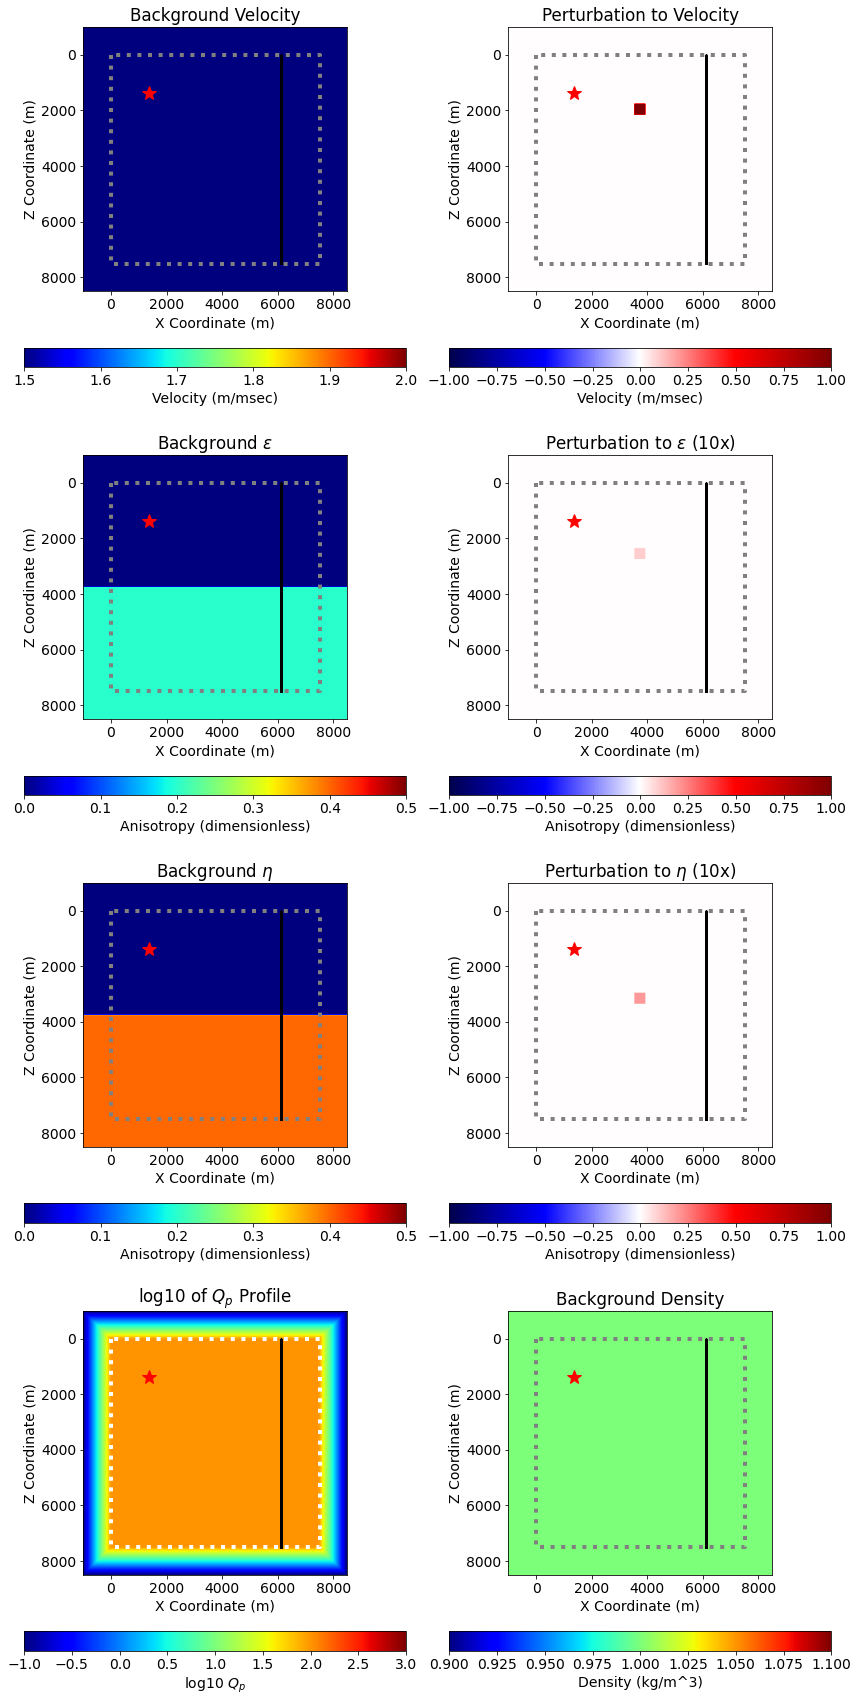

In [7]:
#NBVAL_INGNORE_OUTPUT

# Note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
              origin_pad[1] + extent_pad[1], origin_pad[1]]

vmin, vmax = 1.5, 2.0   # velocity min/max
amin, amax = 0.0, 0.5   # anisotropy min/max
bmin, bmax = 0.9, 1.1   # buoyancy min/max
dmin, dmax = -1, +1     # perturbation min/max

q = w / wOverQ.data[:]

x1 = 0.0
x2 = dx * nx
z1 = 0.0
z2 = dz * nz
abcX = [x1,x1,x2,x2,x1]
abcZ = [z1,z2,z2,z1,z1]

plt.figure(figsize=(12,24))

# Background model parameters
plt.subplot(4, 2, 1)
plt.imshow(np.transpose(vel0.data), cmap=cm.jet, 
           vmin=vmin, vmax=vmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Background Velocity")

plt.subplot(4, 2, 3)
plt.imshow(np.transpose(eps0.data), cmap=cm.jet, 
           vmin=amin, vmax=amax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Anisotropy (dimensionless)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Background $\epsilon$")

plt.subplot(4, 2, 5)
plt.imshow(np.transpose(eta0.data), cmap=cm.jet, 
           vmin=amin, vmax=amax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Anisotropy (dimensionless)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Background $\eta$")

plt.subplot(4, 2, 7)
plt.imshow(np.transpose(np.log10(q.data)), cmap=cm.jet,
           vmin=np.log10(qmin), vmax=np.log10(qmax), extent=plt_extent)
plt.plot(abcX, abcZ, 'white', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='log10 $Q_p$')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("log10 of $Q_p$ Profile")

# Perturbation parameters
plt.subplot(4, 2, 2)
plt.imshow(np.transpose(dvel.data), cmap="seismic", 
           vmin=dmin, vmax=dmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Perturbation to Velocity")

plt.subplot(4, 2, 4)
plt.imshow(np.transpose(10 * deps.data), cmap="seismic", 
           vmin=dmin, vmax=dmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Anisotropy (dimensionless)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Perturbation to $\epsilon$ (10x)")

plt.subplot(4, 2, 6)
plt.imshow(np.transpose(10 * deta.data), cmap="seismic", 
           vmin=dmin, vmax=dmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Anisotropy (dimensionless)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Perturbation to $\eta$ (10x)")

plt.subplot(4, 2, 8)
plt.imshow(np.transpose(1 / b.data), cmap=cm.jet,
           vmin=bmin, vmax=bmax, extent=plt_extent)
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.plot(rec_nl.coordinates.data[:, 0], rec_nl.coordinates.data[:, 1], \
         'black', linestyle='None', marker='^', markersize=2, label="Receivers")
plt.colorbar(orientation='horizontal', label='Density (kg/m^3)')
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Background Density")

plt.tight_layout()
None

## Define pressure wavefields

In this notebook we will first demonstrate the nonlinear operator, which requires only 3 time-levels for the second order time differencing. We will create  state variables for quasi-P and quasi-M nonlinear wavefields. 

For the workflow using the Jacobian operator below, we will need to save all time steps. There are other ways to implement this requirement, including checkpointing, but that is way outside the scope of this illustrative workflow.

In [8]:
# Define the TimeFunctions for nonlinear and Jacobian operations
nt = time_range.num
p0 = TimeFunction(name="p0", grid=grid, time_order=2, space_order=space_order, save=None)
m0 = TimeFunction(name="m0", grid=grid, time_order=2, space_order=space_order, save=None)

# Get the dimensions for t, x, z 
t,x,z = p0.dimensions

## Implement and run the nonlinear operator

We next transcribe the time update expression for the nonlinear operator above into a Devito ```Eq```. Then we add the source injection and receiver extraction and build an ```Operator``` that will generate the c code for performing the modeling.

We copy the time update expression from above, but omit the source term $q$ because for the nonlinear operator we explicitly inject the source using ```src_term```. 

Note we simplify to 2D for the following.

$$
\begin{aligned}
p(t+\Delta_t) = \frac{\Delta_t^2\ m^2}{b} \biggl\{ 
  & \tilde{g}_1 \left[b\ \bigl(1 + 2\ \epsilon\bigr)\ g_1\ p(t) \right] + 
    \tilde{g}_3 \left[b\ \bigl(1 - f\ \tilde{\eta}^2\bigr) g_3\ p(t) \right] + \\[5pt]
  & \tilde{g}_3 \left[b\ f\ \tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ g_3\ m(t) \right] + q_p 
\biggr\} 
    + \biggl( 2 -  \Delta_t \frac{\omega_c}{Q} \biggr)\ p(t) 
    + \biggl( \Delta_t \frac{\omega_c}{Q} - 1 \biggr)\ p(t-\Delta_t)\\[20pt]
% 
p(t+\Delta_t) = \frac{\Delta_t^2\ m^2}{b} \biggl\{ 
  & \tilde{g}_1 \left[b\ \bigl(1 - f\bigr)\ g_1\ m(t) \right] + 
    \tilde{g}_3 \left[b\ \bigl(1 - f + f\ \tilde{\eta}^2\bigr)\ g_3\ m(t) \right] + \\[5pt]
  & \tilde{g}_3 \left[b\ f\ \tilde{\eta}\ \sqrt{1 - \tilde{\eta}^2}\ g_3\ p(t) \right]
\biggr\} 
    + \biggl( 2 -  \Delta_t \frac{\omega_c}{Q} \biggr)\ m(t) 
    + \biggl( \Delta_t \frac{\omega_c}{Q} - 1 \biggr)\ m(t-\Delta_t)
\end{aligned}
$$

## Source injection and receiver extraction for nonlinear forward operator

Source injection and receiver extraction follow the implementation shown in the first notebook, please refer there for more information. 

In [9]:
#NBVAL_IGNORE_OUTPUT

# Time update equation for quasi-P state variable p
update_p_nl = t.spacing**2 * vel0**2 / b * \
    (g1_tilde(b * (1 + 2 * eps0) * g1(p0)) +
     g3_tilde(b * (1 - f * eta0**2) * g3(p0) +
              b * f * eta0 * sqrt(1 - eta0**2) * g3(m0))) + \
    (2 - t.spacing * wOverQ) * p0 + \
    (t.spacing * wOverQ - 1) * p0.backward

# Time update equation for quasi-S state variable m
update_m_nl = t.spacing**2 * vel0**2 / b * \
    (g1_tilde(b * (1 - f) * g1(m0)) +
     g3_tilde(b * (1 - f + f * eta0**2) * g3(m0) +
              b * f * eta0 * sqrt(1 - eta0**2) * g3(p0))) + \
    (2 - t.spacing * wOverQ) * m0 + \
    (t.spacing * wOverQ - 1) * m0.backward

stencil_p_nl = Eq(p0.forward, update_p_nl)
stencil_m_nl = Eq(m0.forward, update_m_nl)

# Update the dimension spacing_map to include the time dimension
# Please refer to the first implementation notebook for more information
spacing_map = grid.spacing_map
spacing_map.update({t.spacing : dt})
print("spacing_map; ", spacing_map)

# Source injection and Receiver extraction
src_term_nl = src_nl.inject(field=p0.forward, expr=src_nl * t.spacing**2 * vel0**2 / b)
rec_term_nl = rec_nl.interpolate(expr=p0.forward)

# Instantiate and run the operator for the nonlinear forward
op_nl = Operator([stencil_p_nl, stencil_m_nl, src_term_nl, rec_term_nl], subs=spacing_map)

spacing_map;  {h_x: 10.0, h_z: 10.0, dt: 1.0}


Operator `Kernel` generated in 3.18 s
  * lowering.Expressions: 1.74 s (54.9 %)
  * lowering.Clusters: 1.02 s (32.2 %)
Flops reduction after symbolic optimization: [1052 --> 233]


## Run modeling for full anisotropic, $\epsilon = 0$, and $\tilde{\eta} = 0$ 

As in the first isotropic notebook, we can run the operator multiple times and supply different ```Functions``` to generate different results. We will create a ```Function``` with zero values in order to generate results for the three cases in the table below. 

#### Material parameters for the 3 cases 
$\tilde{\eta}$ is defined as above and must be greater than $\delta$.

$$
\tilde{\eta} = \sqrt{\frac{\displaystyle 2\bigl(\epsilon - \delta\bigr)}{\displaystyle f + 2\ \epsilon}}
$$
<br>

| Case | &nbsp; &nbsp; Velocity &nbsp; &nbsp; | &nbsp; &nbsp; $\epsilon$ &nbsp; &nbsp; | &nbsp; &nbsp; $\delta$ &nbsp; &nbsp; | &nbsp; &nbsp; $\tilde{\eta}$ &nbsp; &nbsp; |
| :--- | :---: | :---: | :---: | :---: |
| Isotropic | 1.50 | 0.00 | 0.00 | 0.00 | 
| Elliptical Anisotropic | 1.50 | 0.20 | 0.20 | 0.0 | 
| Full Anisotropic | 1.50 | 0.20 | 0.10 | 0.40 | 


In [10]:
# Define TimeFunctions and Functions for isotropic 
p_iso = TimeFunction(name="p_iso", grid=grid, time_order=2, space_order=space_order, save=None)
m_iso = TimeFunction(name="m_iso", grid=grid, time_order=2, space_order=space_order, save=None)
eps_iso = Function(name='eps_iso', grid=grid, space_order=space_order)
eta_iso = Function(name='eta_iso', grid=grid, space_order=space_order)
eps_iso.data[:] = 0.0
eta_iso.data[:] = 0.0

# Define TimeFunctions and Functions for elliptic anisotropic 
p_ell = TimeFunction(name="p_ell", grid=grid, time_order=2, space_order=space_order, save=None)
m_ell = TimeFunction(name="m_ell", grid=grid, time_order=2, space_order=space_order, save=None)
eps_ell = Function(name='eps_ell', grid=grid, space_order=space_order)
eta_ell = Function(name='eta_ell', grid=grid, space_order=space_order)
eps_ell.data[:] = eps0.data[:]
eta_ell.data[:] = 0.0

# Define TimeFunctions and Functions for full anisotropic 
p_full = TimeFunction(name="p_full", grid=grid, time_order=2, space_order=space_order, save=None)
m_full = TimeFunction(name="m_full", grid=grid, time_order=2, space_order=space_order, save=None)
eps_full = Function(name='eps_full', grid=grid, space_order=space_order)
eta_full = Function(name='eta_full', grid=grid, space_order=space_order)
eps_full.data[:] = eps0.data[:]
eta_full.data[:] = eta0.data[:]

Allocating memory for eps_iso(967, 967)
Allocating memory for eta_iso(967, 967)
Allocating memory for eps_ell(967, 967)
Allocating memory for eta_ell(967, 967)
Allocating memory for eps_full(967, 967)
Allocating memory for eta_full(967, 967)


In [11]:
#NBVAL_INGNORE_OUTPUT

# Modeling
op_nl.apply(p0=p_iso, m0=m_iso, eps0=eps_iso, eta0=eta_iso)
op_nl.apply(p0=p_ell, m0=m_ell, eps0=eps_ell, eta0=eta_ell)
op_nl.apply(p0=p_full, m0=m_full, eps0=eps_full, eta0=eta_full)

None

Allocating memory for m_iso(3, 967, 967)
Allocating memory for p_iso(3, 967, 967)
Allocating memory for rec_nl(3001, 751)
Operator `Kernel` fetched `/tmp/devito-jitcache-uid5138/f245c8d9ea851d116dff4b04f37696739d91257e.c` in 0.23 s from jit-cache
Operator `Kernel` run in 10.04 s
Global performance indicators
  * Achieved 0.27 FD-GPts/s
Local performance indicators
  * section0<951,958> with OI=0.38 computed in 0.01 s [4.06 GFlops/s]
  * section1<<2999,958,958>,<2999,951,951>> with OI=2.60 computed in 9.85 s [63.64 GFlops/s, 0.56 GPts/s]
  * section2<<2999,1>,<2999,1>,<2999,1>,<2999,1>,<2999,1>> with OI=3.85 computed in 0.12 s [0.01 GFlops/s, 0.01 GPts/s]
  * section3<<2999,751>,<2999,751>,<2999,751>,<2999,751>,<2999,751>,<2999,751>> with OI=4.84 computed in 0.08 s [1.75 GFlops/s]
Performance[mode=advanced] arguments: {'nthreads': 16, 'nthreads_nonaffine': 16}
Allocating memory for m_ell(3, 967, 967)
Allocating memory for p_ell(3, 967, 967)
Operator `Kernel` run in 9.98 s
Global perform

In [12]:
# Report min/max amplitudes
n = 1

p_iso_min,p_iso_max = np.min(p_iso.data[n,:,:]), np.max(p_iso.data[n,:,:])
m_iso_min,m_iso_max = np.min(m_iso.data[n,:,:]), np.max(m_iso.data[n,:,:])

p_ell_min,p_ell_max = np.min(p_ell.data[n,:,:]), np.max(p_ell.data[n,:,:])
m_ell_min,m_ell_max = np.min(m_ell.data[n,:,:]), np.max(m_ell.data[n,:,:])

p_full_min,p_full_max = np.min(p_full.data[n,:,:]), np.max(p_full.data[n,:,:])
m_full_min,m_full_max = np.min(m_full.data[n,:,:]), np.max(m_full.data[n,:,:])

print("Isotropic            pmin,pmax,smin,smax ; %+12.6e %+12.6e %+12.6e %+12.6e" % \
      (p_iso_min, p_iso_max, m_iso_min, m_iso_max))
print("Elliptic Anisotropic pmin,pmax,smin,smax ; %+12.6e %+12.6e %+12.6e %+12.6e" % \
      (p_ell_min, p_ell_max, m_ell_min, m_ell_max))
print("Full     Anisotropic pmin,pmax,smin,smax ; %+12.6e %+12.6e %+12.6e %+12.6e" % \
      (p_full_min, p_full_max, m_full_min, m_full_max))

Isotropic            pmin,pmax,smin,smax ; -3.594371e-01 +5.708246e-01 +0.000000e+00 +0.000000e+00
Elliptic Anisotropic pmin,pmax,smin,smax ; -4.864602e-01 +8.026226e-01 +0.000000e+00 +0.000000e+00
Full     Anisotropic pmin,pmax,smin,smax ; -5.025669e-01 +8.240436e-01 -4.074297e-01 +2.322675e-01


## Plot the quasi-P and quasi-S nonlinear forward wavefields

Below we show the quasi-P nonlinear wavefields for the 3 different cases at the end of the modeling. We also show the quasi-S nonlinear wavefield for the full anisotropic case. Note that the quasi-S wavefield are zero for the isotropic and elliptical cases as nothing can be coupled from quasi-P to quasi-S wavefields when $\tilde{\eta}$ is zero. 

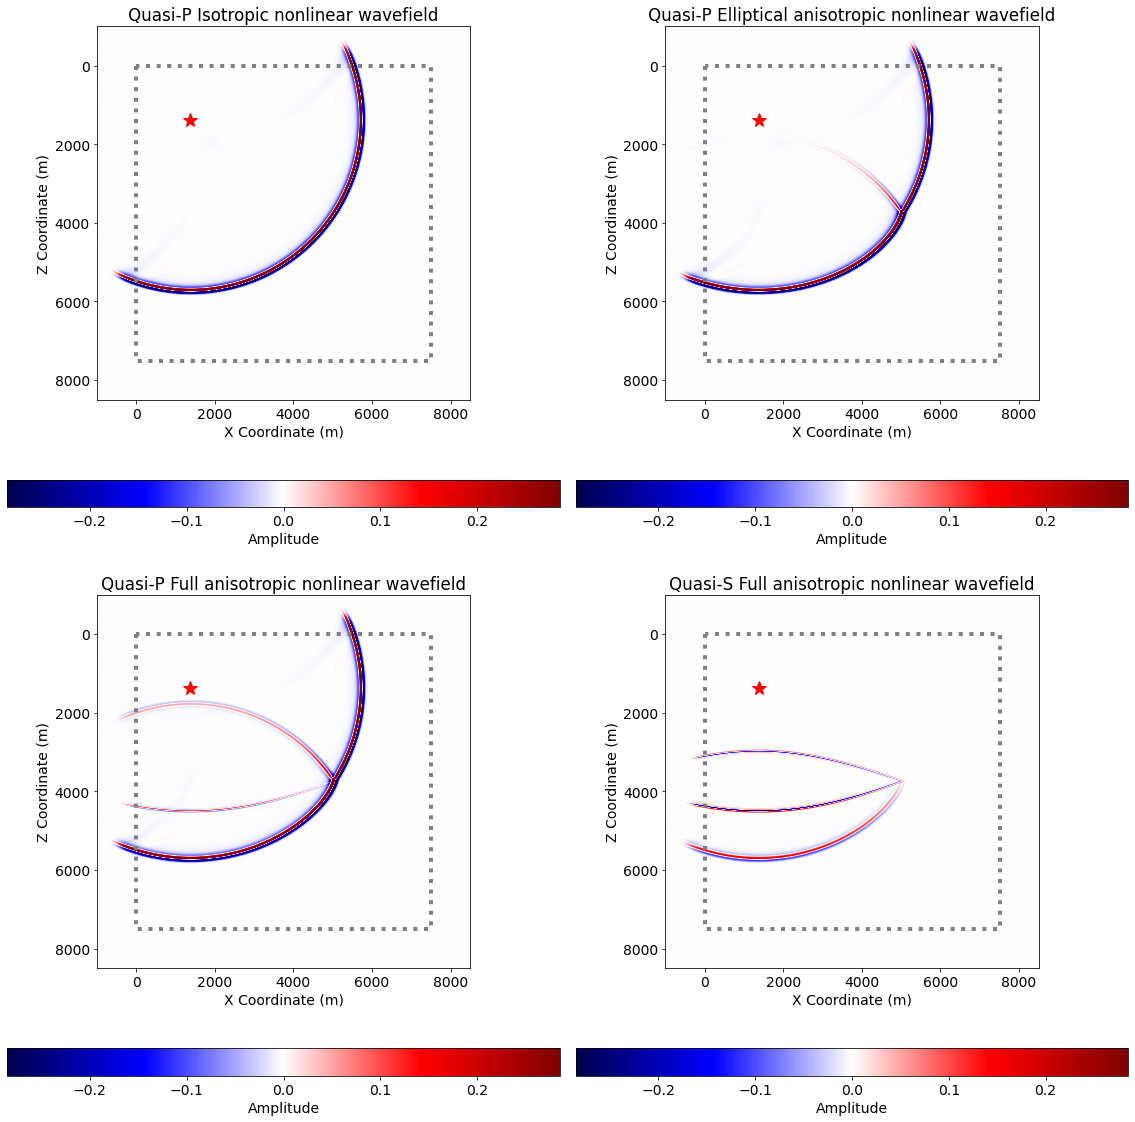

In [13]:
#NBVAL_INGNORE_OUTPUT

# Plot the two wavefields, each normalized to own maximum
amax1 = np.max(np.abs(p_iso.data[1,:,:])) / 2.0

plt.figure(figsize=(16,16))

plt.subplot(2, 2, 1)
plt.imshow(np.transpose(p_iso.data[1,:,:]), cmap="seismic", 
           vmin=-amax1, vmax=+amax1, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Quasi-P Isotropic nonlinear wavefield")

plt.subplot(2, 2, 2)
plt.imshow(np.transpose(p_ell.data[1,:,:]), cmap="seismic",
           vmin=-amax1, vmax=+amax1, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Quasi-P Elliptical anisotropic nonlinear wavefield")

plt.subplot(2, 2, 3)
plt.imshow(np.transpose(p_full.data[1,:,:]), cmap="seismic",
           vmin=-amax1, vmax=+amax1, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Quasi-P Full anisotropic nonlinear wavefield")

plt.subplot(2, 2, 4)
plt.imshow(np.transpose(m_full.data[1,:,:]), cmap="seismic",
           vmin=-amax1, vmax=+amax1, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Amplitude')
plt.plot(abcX, abcZ, 'gray', linewidth=4, linestyle=':', label="Absorbing Boundary")
plt.plot(src_nl.coordinates.data[:, 0], src_nl.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Quasi-S Full anisotropic nonlinear wavefield")

plt.tight_layout()
None

## Regenerate nonlinear operator, saving all time steps

Required for the Jacobian ops

## Discussion

This concludes the implementation of the nonlinear forward operator. This series continues in the next notebook that describes the implementation of the Jacobian linearized forward and adjoint operators.

[ssa_02_iso_implementation2.ipynb](ssa_02_iso_implementation2.ipynb)


<a id="refs"></a>
## References

- **A nonreflecting boundary condition for discrete acoustic and elastic wave equations** (1985)
<br>Charles Cerjan, Dan Kosloff, Ronnie Kosloff, and Moshe Resheq
<br> Geophysics, Vol. 50, No. 4
<br>https://library.seg.org/doi/pdfplus/10.1190/segam2016-13878451.1

- **Generation of Finite Difference Formulas on Arbitrarily Spaced Grids** (1988)
<br>Bengt Fornberg
<br>Mathematics of Computation, Vol. 51, No. 184
<br>http://dx.doi.org/10.1090/S0025-5718-1988-0935077-0
<br>https://web.njit.edu/~jiang/math712/fornberg.pdf

- **Self-adjoint, energy-conserving second-order pseudoacoustic systems for VTI and TTI media for reverse time migration and full-waveform inversion** (2016)
<br>Kenneth Bube, John Washbourne, Raymond Ergas, and Tamas Nemeth
<br>SEG Technical Program Expanded Abstracts
<br>https://library.seg.org/doi/10.1190/segam2016-13878451.1
